
# 📘 Main Notebook — Clean Orchestrator

This notebook **reproduces the TEST-period tables** and **runs the option-pricing diagnostics** using the exact same inputs and logic as your original script, but organized into clear sections with runtime toggles.

- **Part A.** TEST-period tables: builds and saves
  - `paper_outputs/TABLE_master_by_algo_best_per_method_TEST.(csv|tex)`  
  - `paper_outputs/TABLE_best_configs_long_TEST.(csv|tex)`  
  - `paper_outputs/TABLE_method_averages_across_algos_TEST.(csv|tex)`  
  - `paper_outputs/TABLE_paired_sharpe_diffs_TEST.(csv|tex)`  
  - `paper_outputs/TEST_analysis_summary.csv`
- **Part B.** Signature KRR / RFSF option fitting & diagnostics with publication-ready figures.


In [2]:

# ---- Runtime toggles ----
RUN_PART_A = True         # TEST-period tables
RUN_PART_B = True         # Option pricing diagnostics
RUN_EXTENDED = True       # Extended metrics/plots for Part B
RUN_CROSS_MATURITY = False  # Cross-maturity generalization (Part B)

print("Toggles ->", dict(RUN_PART_A=RUN_PART_A, RUN_PART_B=RUN_PART_B, RUN_EXTENDED=RUN_EXTENDED, RUN_CROSS_MATURITY=RUN_CROSS_MATURITY))


Toggles -> {'RUN_PART_A': True, 'RUN_PART_B': True, 'RUN_EXTENDED': True, 'RUN_CROSS_MATURITY': False}



## ⚙️ Setup

Minimal imports and warning suppression. The cells below expect your **data** under `data/` and **results** under `results/`.


In [3]:

import os, sys, re, json, math, warnings, datetime as dt
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd

from IPython.display import display

# Optional deps for Part B (loaded lazily):
#   yfinance, iisignature, matplotlib, scipy
print("Environment ready.")


Environment ready.



---

# 🅰️ Part A — TEST-Period Tables (repro)

Builds summary tables by scanning `results/` and saves LaTeX/CSV to `paper_outputs/`. Displays all tables inline.


### 🔧 Part A — Config

In [4]:

# ------------------ FIXED PARAMETERS ------------------
DATA_DIR     = Path("data")
RESULTS_ROOT = Path("results")
OUT_DIR      = Path("paper_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

YEARS     = 10
SPLIT     = 0.60
VAL_SPLIT = 0.10
MODE_KEY  = "test"  # <- test period only

# Embedded config (no external imports)
BENCHMARK = ["^DJI"]
ASSETS = [
    "NVDA","MSFT","AAPL","AMZN","JPM","WMT","V","PG","JNJ","HD",
    "KO","UNH","CSCO","IBM","CRM","CVX","DIS","AXP","MCD","GS",
    "MRK","CAT","VZ","BA","AMGN","HON","NKE","SHW","MMM","TRV"
]

print("Part A config set. Outputs ->", OUT_DIR.as_posix())


Part A config set. Outputs -> paper_outputs


### 🧩 Part A — Loaders & Metrics

In [5]:

# ----------------- Robust price loading -----------------
def _read_close_from_csv(csv_path: Path, tk: str) -> pd.Series:
    """Load a single ticker's Close column from CSV with robust header handling."""
    # Try multi-index header first
    try:
        df2 = pd.read_csv(csv_path, index_col=0, parse_dates=True, header=[0,1])
        if isinstance(df2.columns, pd.MultiIndex):
            cols = [c for c in df2.columns if c[0] == "Close"]
            if not cols:
                raise KeyError("No 'Close' columns in MultiIndex CSV")
            ser = df2[("Close", tk)] if ("Close", tk) in df2.columns else df2[cols[0]]
            ser = pd.to_numeric(ser, errors="coerce").dropna().astype(np.float32)
            ser.name = tk
            return ser
    except Exception:
        pass
    # Fallback: single header
    df = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    if "Close" not in df.columns:
        raise ValueError(f"'Close' not found in {csv_path}")
    ser = pd.to_numeric(df["Close"], errors="coerce").dropna().astype(np.float32)
    ser.name = tk
    return ser


def _load_prices(data_dir: Path, tickers, years: int) -> pd.DataFrame:
    if isinstance(tickers, str):
        tickers = [tickers]
    end   = dt.datetime.utcnow().replace(tzinfo=None)
    start = end - dt.timedelta(days=365 * years)
    series = []
    for tk in tickers:
        csv_path = data_dir / f"{tk.replace('^','')}.csv"
        if not csv_path.exists():
            raise FileNotFoundError(f"Missing cached CSV for {tk}: {csv_path}")
        series.append(_read_close_from_csv(csv_path, tk))
    df = pd.concat(series, axis=1).sort_index()
    return df.loc[start:end].dropna().astype(np.float32)

# ------------------- Metrics -------------------
def _to_np(x):
    arr = np.asarray(x, dtype=np.float64)
    return arr[~np.isnan(arr)]

def sharpe(r, rf=0.0):
    r = _to_np(r)
    if len(r) < 2: return np.nan
    ex = r - rf; sd = ex.std(ddof=1)
    return np.nan if sd == 0 else ex.mean()/sd*np.sqrt(252)

def sortino(r, rf=0.0):
    r = _to_np(r)
    if len(r) < 2: return np.nan
    dn = np.minimum(0.0, r - rf); dd = dn.std(ddof=1)
    return np.nan if dd == 0 else (r - rf).mean()/dd*np.sqrt(252)

def annualized_return(r):
    r = _to_np(r)
    if len(r)==0: return np.nan
    total = (1.0 + r).prod(); years = len(r)/252.0
    return total**(1/years) - 1.0

def max_drawdown(r):
    eq = np.cumprod(1.0 + _to_np(r))
    peak = np.maximum.accumulate(eq)
    return ((eq - peak)/peak).min()

def info_ratio(strategy_r, bench_r):
    s = _to_np(strategy_r); b = _to_np(bench_r)
    n = min(len(s), len(b))
    if n < 2: return np.nan
    diff = s[:n] - b[:n]; te = diff.std(ddof=1)
    return np.nan if te == 0 else diff.mean()/te*np.sqrt(252)


In [6]:

# ---------------- Discover runs ----------------
JSON_RE = re.compile(r"lam_(?P<lam>[\d\.]+)_hparams\.json$")

def discover_runs(results_root: Path) -> pd.DataFrame:
    rows = []
    if not results_root.exists():
        return pd.DataFrame(rows)
    for method_dir in results_root.iterdir():
        if not method_dir.is_dir(): continue
        method = method_dir.name  # vanilla, sk, sf
        for algo_dir in method_dir.iterdir():
            if not algo_dir.is_dir(): continue
            base_algo = algo_dir.name
            for bench_dir in algo_dir.iterdir():
                if not bench_dir.is_dir(): continue
                bench_tag = bench_dir.name
                for jf in bench_dir.glob("lam_*_hparams.json"):
                    m = JSON_RE.search(jf.name)
                    if not m: continue
                    lam = float(m.group("lam"))
                    rows.append({
                        "method": method, "base_algo": base_algo,
                        "bench_tag": bench_tag, "lam": lam, "json_path": jf
                    })
    return pd.DataFrame(rows)

# ----------------- Utilities to save tables -----------------
def save_table(df: pd.DataFrame, stem: str):
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    df.to_csv(OUT_DIR / f"{stem}.csv", index=False, encoding="utf-8-sig")
    latex = (
        df.copy()
        .rename(columns=lambda c: str(c).replace("_", "\\_"))
        .to_latex(index=False, float_format="%.4g")
    )
    (OUT_DIR / f"{stem}.tex").write_text(latex, encoding="utf-8")


### ▶️ Part A — Run

In [17]:

if RUN_PART_A:
    # ------------- Build TEST index & benchmark -------------
    price_df = _load_prices(DATA_DIR, ASSETS, YEARS)
    n_total  = len(price_df)
    cut_train = int(n_total * SPLIT)
    cut_val   = cut_train + int(n_total * VAL_SPLIT)
    test_idx  = price_df.iloc[cut_val:].index
    if len(test_idx) < 3:
        raise RuntimeError("Test slice too small; check SPLIT and VAL_SPLIT.")

    bench_df  = _load_prices(DATA_DIR, BENCHMARK, YEARS)
    bench_eqw = bench_df.mean(axis=1) if bench_df.shape[1] > 1 else bench_df.iloc[:,0]
    bench_on_test = bench_eqw.reindex(test_idx, method="ffill")
    bench_test_ret = bench_on_test.pct_change().dropna().values.astype(np.float64)

    # ------------- Summarize runs using test_returns -------------
    runs_df = discover_runs(RESULTS_ROOT)
    if runs_df.empty:
        raise RuntimeError("No runs discovered in 'results/'. Check your training output.")

    records = []
    for _, row in runs_df.iterrows():
        trials = json.loads(row.json_path.read_text()) or []
        if not trials:
            continue
        best = max(trials, key=lambda t: t.get("score", -np.inf))
        test_returns = np.asarray(best.get("test_returns", []), dtype=np.float64)
        if len(test_returns) == 0:
            continue

        bret = (
            bench_test_ret[:len(test_returns)]
            if len(bench_test_ret) >= len(test_returns)
            else np.pad(bench_test_ret, (0, len(test_returns) - len(bench_test_ret)))
        )

        records.append(dict(
            method=row.method, base_algo=row.base_algo, bench_tag=row.bench_tag, lam=row.lam,
            sharpe=sharpe(test_returns), sortino=sortino(test_returns),
            ann_return=annualized_return(test_returns), max_dd=max_drawdown(test_returns),
            info_ratio=info_ratio(test_returns, bret),
            bench_sharpe=sharpe(bret), bench_ann=annualized_return(bret), bench_maxdd=max_drawdown(bret),
        ))

    summary = pd.DataFrame.from_records(records)
    if summary.empty:
        raise RuntimeError("Runs discovered but no trials with nonempty test_returns.")

    # ----------------- Build dissertation tables -----------------
    # A) Best-per-method per base algorithm (wide)
    best_rows = (
        summary.sort_values("sharpe", ascending=False)
               .groupby(["method","base_algo"], as_index=False)
               .head(1)
    )

    from functools import reduce
    def _flatten_cols(method_prefix, df_subset):
        df_subset = df_subset.rename(columns={
            "sharpe": f"{method_prefix}_Sharpe",
            "info_ratio": f"{method_prefix}_Info",
            "ann_return": f"{method_prefix}_AnnRet",
            "max_dd": f"{method_prefix}_MaxDD",
            "lam": f"{method_prefix}_lambda",
            "bench_tag": f"{method_prefix}_bench",
        })
        keep = [
            "base_algo", f"{method_prefix}_bench", f"{method_prefix}_lambda",
            f"{method_prefix}_Sharpe", f"{method_prefix}_Info",
            f"{method_prefix}_AnnRet", f"{method_prefix}_MaxDD",
        ]
        return df_subset[keep]

    wide_parts = []
    for m in ["vanilla","sk","sf"]:
        sub = best_rows[best_rows["method"]==m].copy()
        if sub.empty:
            continue
        sub = sub[["base_algo","bench_tag","lam","sharpe","info_ratio","ann_return","max_dd"]]
        wide_parts.append(_flatten_cols(m, sub))

    if not wide_parts:
        raise RuntimeError("No best rows found to assemble master table.")

    table_wide = reduce(lambda L,R: pd.merge(L,R,on="base_algo",how="outer"), wide_parts)
    table_wide = table_wide.sort_values("base_algo").reset_index(drop=True)
    save_table(table_wide, "TABLE_master_by_algo_best_per_method_TEST")

    # B) Long best-configs table (tidy)
    table_long = (
        best_rows
        .loc[:, ["method","base_algo","bench_tag","lam","sharpe","info_ratio","ann_return","max_dd"]]
        .sort_values(["base_algo","method"]) 
        .reset_index(drop=True)
    )
    save_table(table_long, "TABLE_best_configs_long_TEST")

    # C) Method averages across algorithms (using best per method per algo)
    method_avgs = (
        table_long
        .groupby("method", as_index=False)
        .agg(mean_sharpe=("sharpe","mean"),
             mean_info=("info_ratio","mean"),
             mean_ann_ret=("ann_return","mean"),
             mean_max_dd=("max_dd","mean"),
             n_algos=("base_algo","nunique"))
        .sort_values("mean_sharpe", ascending=False)
        .reset_index(drop=True)
    )
    save_table(method_avgs, "TABLE_method_averages_across_algos_TEST")

    # ----------------- Paired differences (Sharpe) -----------------
    def bootstrap_ci(values, n_boot=5000, alpha=0.05, seed=42, agg_fn=np.mean):
        rng = np.random.default_rng(seed)
        vals = np.asarray(values, dtype=float)
        vals = vals[~np.isnan(vals)]
        if len(vals) == 0:
            return (np.nan, np.nan)
        n = len(vals)
        boots = [agg_fn(vals[rng.integers(0, n, size=n)]) for _ in range(n_boot)]
        return np.quantile(boots, alpha/2), np.quantile(boots, 1 - alpha/2)

    def paired_diffs(df, method_a, method_b, metric="sharpe"):
        A = df[df["method"]==method_a].set_index(["base_algo","bench_tag","lam"])
        B = df[df["method"]==method_b].set_index(["base_algo","bench_tag","lam"])
        common = A.join(B, lsuffix="_A", rsuffix="_B", how="inner")
        diff = common[f"{metric}_A"] - common[f"{metric}_B"]
        return diff

    rows = []
    for m in ["sk", "sf"]:
        diff = paired_diffs(summary, m, "rl", "sharpe")
        n = int(diff.notna().sum())
        mean = float(np.nanmean(diff))
        median = float(np.nanmedian(diff))
        lo, hi = bootstrap_ci(diff.values)
        rows.append(dict(
            contrast=f"{m} vs vanilla",
            n=n,
            mean_diff=mean,
            median_diff=median,
            ci_lo=lo,
            ci_hi=hi,
        ))

    t_paired = pd.DataFrame(rows)
    save_table(t_paired, "TABLE_paired_sharpe_diffs_TEST")

    # ----------------- Display inline in the notebook -----------------
    print("✅ Saved tables to 'paper_outputs/'. Displaying below:")
    print("\nTABLE_master_by_algo_best_per_method_TEST")
    display(table_wide)
    print("\nTABLE_best_configs_long_TEST")
    display(table_long)
    print("\nTABLE_method_averages_across_algos_TEST")
    display(method_avgs)
    print("\nTABLE_paired_sharpe_diffs_TEST")
    display(t_paired)
else:
    print("Part A skipped.")


✅ Saved tables to 'paper_outputs/'. Displaying below:

TABLE_master_by_algo_best_per_method_TEST


,base_algo,sk_bench,sk_lambda,sk_Sharpe,sk_Info,sk_AnnRet,sk_MaxDD,sf_bench,sf_lambda,sf_Sharpe,sf_Info,sf_AnnRet,sf_MaxDD
0,a2c,^DJI,5.0,1.467567,0.521814,0.221066,-0.138696,^DJI,1.5,1.781889,0.886459,0.333194,-0.180473
1,ddpg,^DJI,1.0,1.522922,0.597985,0.243417,-0.161232,^DJI,1.0,1.429442,0.522649,0.223306,-0.154147
2,ppo,^DJI,3.5,1.733493,0.823013,0.309600,-0.164587,^DJI,2.0,1.499907,0.670982,0.270136,-0.190116
3,sac,^DJI,0.0,1.413781,0.533031,0.210755,-0.158307,^DJI,3.0,1.453474,0.490357,0.212308,-0.157393
4,td3,^DJI,0.5,1.417123,0.472175,0.209051,-0.148359,^DJI,1.5,1.466926,0.548595,0.229858,-0.158908



TABLE_best_configs_long_TEST


,method,base_algo,bench_tag,lam,sharpe,info_ratio,ann_return,max_dd
0,rl,a2c,^DJI,0.5,1.511825,0.530978,0.205891,-0.148127
1,sf,a2c,^DJI,1.5,1.781889,0.886459,0.333194,-0.180473
2,sk,a2c,^DJI,5.0,1.467567,0.521814,0.221066,-0.138696
3,rl,ddpg,^DJI,5.0,1.427521,0.573119,0.237761,-0.168775
4,sf,ddpg,^DJI,1.0,1.429442,0.522649,0.223306,-0.154147
5,sk,ddpg,^DJI,1.0,1.522922,0.597985,0.243417,-0.161232
6,rl,ppo,^DJI,5.0,1.548520,0.533782,0.221577,-0.151326
7,sf,ppo,^DJI,2.0,1.499907,0.670982,0.270136,-0.190116
8,sk,ppo,^DJI,3.5,1.733493,0.823013,0.309600,-0.164587
9,rl,sac,^DJI,0.5,1.457120,0.538180,0.210631,-0.151548



TABLE_method_averages_across_algos_TEST


,method,mean_sharpe,mean_info,mean_ann_ret,mean_max_dd,n_algos
0,sf,1.526328,0.623808,0.253760,-0.168207,5
1,sk,1.510977,0.589603,0.238778,-0.154236,5
2,rl,1.457614,0.535529,0.215964,-0.158104,5



TABLE_paired_sharpe_diffs_TEST


,contrast,n,mean_diff,median_diff,ci_lo,ci_hi
0,sk vs vanilla,55,-0.010216,-0.020151,-0.111641,0.094004
1,sf vs vanilla,55,-0.012828,-0.086714,-0.113767,0.086584



---

# 🅱️ Part B — Option Pricing: Sig-KRR / RFSF Diagnostics

Publication-ready option fitting & diagnostics with **signature KRR**, **RFSF**, and a **Black–Scholes baseline**.
- Spread-aware loss, derivative penalty terms.
- Monotonicity (calls non-increasing, puts non-decreasing) & convexity checks.
- Figures saved to `figures/` (PNG + PDF).


### 🔧 Part B — Config

In [18]:

import numpy as np, pandas as pd, os

# -------------------- SETTINGS --------------------
TICKER        = "SPY"
EXPIRY        = "2025-09-19"

# signature + RFSF
SIG_ORDER     = 6
L_TS          = 25           # steps before lead–lag
RIDGE_LAMBDA  = 1e-5         # base ridge (will be CV'd)
FD_STEP       = None         # if None -> set adaptively
D_RFSF        = 1500

# finance
R_RATE        = 0.02
TOL_VIOL      = 1e-4

# data fallbacks (CSV paths if you want to bypass live)
CSV_CALLS     = None
CSV_PUTS      = None

# eval/filter
MAX_SPREAD_FRAC = 0.20       # drop quotes with (ask-bid)/mid > 20%
MIN_MID_PRICE   = 0.05
BOOTSTRAP_B     = 1000
CV_FOLDS        = 5
RNG_SEED        = 42

# spread-aware fit & no-arb projection
ETA_SPREAD      = 1.0        # tune ~0.3–3.0
ENFORCE_NO_ARB  = False

# figure output
SAVE_FIGS       = True
FIG_DIR         = "figures"
FIG_DPI         = 300

np.random.seed(RNG_SEED)

# -------------------- PUBLICATION STYLE --------------------
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def set_pub_style():
    plt.rcParams.update({
        "figure.dpi": FIG_DPI,
        "savefig.dpi": FIG_DPI,
        "figure.figsize": (22, 4.8),
        "font.size": 13,
        "axes.titlesize": 14,
        "axes.labelsize": 13,
        "legend.fontsize": 12,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "TeX Gyre Termes", "DejaVu Serif", "serif"],
        "axes.grid": True,
        "grid.alpha": 0.22,
        "grid.linestyle": "--",
        "lines.linewidth": 1.8,
        "lines.markersize": 4.5,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
    })
set_pub_style()

os.makedirs(FIG_DIR, exist_ok=True)

def save_figure(fig, basename):
    safe = "".join(c if c.isalnum() or c in "-_" else "_" for c in basename)
    png_path = os.path.join(FIG_DIR, f"{safe}.png")
    pdf_path = os.path.join(FIG_DIR, f"{safe}.pdf")
    fig.tight_layout()
    fig.savefig(png_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"[FIG] Saved {png_path} and {pdf_path}")


### 🧩 Part B — Market Data & Utilities

In [19]:

import yfinance as yf

def fetch_options(ticker, expiry, calls_csv=None, puts_csv=None):
    try:
        ch = yf.Ticker(ticker).option_chain(expiry)
        calls, puts = ch.calls, ch.puts
        print("[INFO] Pulled live option chain.")
    except Exception as e:
        print(f"[WARN] Live fetch failed: {e}")
        if not (calls_csv and puts_csv):
            raise RuntimeError("No CSV fallbacks provided.")
        calls = pd.read_csv(calls_csv)
        puts  = pd.read_csv(puts_csv)
        print("[INFO] Loaded option chain from CSV fallback.")
    return calls, puts

def clean_chain(df):
    strikes = df["strike"].astype(float).to_numpy()
    bid     = df["bid"].astype(float).to_numpy()
    ask     = df["ask"].astype(float).to_numpy()
    mid     = 0.5*(bid+ask)
    spr     = ask - bid
    m = np.isfinite(bid) & np.isfinite(ask) & (bid>0) & (ask>0)         & (mid>MIN_MID_PRICE) & ((spr / np.maximum(mid,1e-12)) <= MAX_SPREAD_FRAC)
    return strikes[m], bid[m], ask[m]

def join_common_strikes(Kc, mid_c, Kp, mid_p):
    dfc = pd.DataFrame({"K": Kc, "Cmid": mid_c})
    dfp = pd.DataFrame({"K": Kp, "Pmid": mid_p})
    df  = pd.merge(dfc, dfp, on="K", how="inner")
    return df["K"].to_numpy(), df["Cmid"].to_numpy(), df["Pmid"].to_numpy()

def estimate_forward_and_q(S, r, T, K, Cmid, Pmid):
    from numpy import log, exp
    F_i = K + np.exp(r*T)*(Cmid - Pmid)
    F   = float(np.median(F_i))
    q   = float(r - (np.log(max(F,1e-12)) - np.log(max(S,1e-12))) / max(T,1e-12))
    return F, q


### 🧮 Part B — Models & Feature Maps

In [20]:

from scipy.stats import norm
from scipy.optimize import minimize_scalar

# -------------------- BLACK–SCHOLES --------------------
def black_scholes_price(K, S, T, r, q, sigma, option_type="call"):
    K = np.asarray(K, dtype=float); S = float(S); r = float(r); q = float(q); T = float(T)
    if T <= 0:
        return np.maximum((S - K) if option_type=="call" else (K - S), 0.0)
    vol = np.maximum(1e-12, np.asarray(sigma, dtype=float))
    if vol.ndim == 0: vol = np.full_like(K, float(vol))
    sqrtT = np.sqrt(T); df_r = np.exp(-r*T); df_q = np.exp(-q*T)
    d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / (vol * sqrtT)
    d2 = d1 - vol * sqrtT
    if option_type == "call":
        return df_q*S * norm.cdf(d1) - df_r*K * norm.cdf(d2)
    else:
        return df_r*K * norm.cdf(-d2) - df_q*S * norm.cdf(-d1)

# -------------------- PATHS & SIGNATURES --------------------
import iisignature

def lead_lag_path(t, x):
    out = [[t[0], x[0], x[0]]]
    for i in range(len(t)-1):
        out.append([t[i+1], x[i+1], x[i]])
        out.append([t[i+1], x[i+1], x[i+1]])
    return np.array(out, dtype=float)

def make_path(K, mu, sigma_w, L=25):
    ts = np.linspace(0.0, 1.0, L)
    x_end = (K - mu) / (sigma_w + 1e-12)
    xs = x_end * ts
    return lead_lag_path(ts, xs)

class SigCache:
    def __init__(self, mu, sigma_w, order):
        self.mu, self.sigma_w, self.order = float(mu), float(sigma_w), int(order)
        self._buf = {}
    def sig_vec(self, K):
        K = float(K)
        if K not in self._buf:
            path = make_path(K, self.mu, self.sigma_w, L=L_TS)
            self._buf[K] = iisignature.sig(path, self.order)
        return self._buf[K]
    def sig_matrix(self, Ks):
        return np.vstack([self.sig_vec(k) for k in Ks])

def _level_slices(d, m):
    idx, start = [], 0
    for k in range(1, m+1):
        ln = d**k; idx.append(slice(start, start+ln)); start += ln
    return idx

def signature_kernel_cached(cache, KsX, KsY, order, include_level0=True):
    d = 3
    X = cache.sig_matrix(KsX); Y = cache.sig_matrix(KsY)
    K = np.zeros((X.shape[0], Y.shape[0]))
    if include_level0: K += 1.0
    for k, sl in enumerate(_level_slices(d, order), start=1):
        K += (X[:, sl] @ Y[:, sl].T) / math.factorial(k)
    return K

def adaptive_fd_step(Ks):
    uk = np.unique(np.sort(Ks))
    if len(uk) < 2: return 0.25
    return 0.5*np.median(np.diff(uk))

def predict_krr(alpha, Ks_fit, Ks_eval, cache, order, h):
    K0  = signature_kernel_cached(cache, Ks_eval,   Ks_fit, order)
    Kp  = signature_kernel_cached(cache, Ks_eval+h, Ks_fit, order)
    Km  = signature_kernel_cached(cache, Ks_eval-h, Ks_fit, order)
    f0  = K0 @ alpha
    d1  = (Kp @ alpha - Km @ alpha) / (2*h)
    d2  = (Kp @ alpha - 2*f0 + Km @ alpha) / (h*h)
    return f0, d1, d2

def build_RFSF_cosine(cache, order, D):
    sig_dim = iisignature.siglength(3, order)
    W = np.random.normal(0, 1, (sig_dim, D))
    b = np.random.uniform(0, 2*np.pi, D)
    def Phi(Ks):
        S = cache.sig_matrix(Ks)
        return np.sqrt(2/D) * np.cos(S @ W + b)
    return Phi

def predict_RFSF(beta, Phi_fn, Ks_eval, h):
    Φ0 = Phi_fn(Ks_eval); Φp = Phi_fn(Ks_eval + h); Φm = Phi_fn(Ks_eval - h)
    f0 = Φ0 @ beta
    d1 = (Φp @ beta - Φm @ beta) / (2*h)
    d2 = (Φp @ beta - 2*f0 + Φm @ beta) / (h*h)
    return f0, d1, d2


### ✅ Part B — Evaluation Helpers

In [21]:

def split_by_strike(strikes, bid, ask, test_frac=0.33):
    idx = np.argsort(strikes)
    strikes = strikes[idx]; bid = bid[idx]; ask = ask[idx]
    n = len(strikes); k = max(3, int(round(1/test_frac)))
    te_idx = np.arange(0, n, k)
    tr_mask = np.ones(n, dtype=bool); tr_mask[te_idx] = False
    return (strikes[tr_mask], bid[tr_mask], ask[tr_mask]), (strikes[~tr_mask], bid[~tr_mask], ask[~tr_mask])

def violations_model_vs_data(Ks, y_data, y_model, tol=1e-4, option_type="call"):
    d1d = np.gradient(y_data, Ks); d2d = np.gradient(np.gradient(y_data, Ks), Ks)
    d1m = np.gradient(y_model, Ks); d2m = np.gradient(np.gradient(y_model, Ks), Ks)
    mono_ok = (d1d <= tol) if (option_type=="call") else (d1d >= -tol)
    conv_ok = (d2d >= -tol)
    if option_type == "call":
        mono_flag = (mono_ok) & (d1m >  tol)
    else:
        mono_flag = (mono_ok) & (d1m < -tol)
    conv_flag = (conv_ok) & (d2m < -tol)
    mono_cnt = int(np.sum(mono_flag)); conv_cnt = int(np.sum(conv_flag))
    mono_l1  = float(np.sum(np.abs(d1m[mono_flag])))
    conv_l1  = float(np.sum(np.abs(d2m[conv_flag])))
    return (mono_cnt, mono_l1), (conv_cnt, conv_l1), mono_flag, conv_flag

def total_variation(arr):
    return float(np.sum(np.abs(np.diff(arr))))

def diff_mat(x):
    x = np.asarray(x, float); n = len(x)
    if n < 3: return np.zeros((n,n))
    D = np.zeros((n, n)); dx = np.diff(x)
    for i in range(1, n-1):
        D[i, i-1] = -1.0/max(dx[i-1],1e-12)
        D[i, i+1] =  1.0/max(dx[i],1e-12)
        D[i, i]   = -(D[i, i-1] + D[i, i+1])
    D[0,0], D[0,1] = -1.0/max(dx[0],1e-12), 1.0/max(dx[0],1e-12)
    D[-1,-2], D[-1,-1] = -1.0/max(dx[-1],1e-12), 1.0/max(dx[-1],1e-12)
    return D

def project_no_arb_1d(K, f, S, T, r, q, option_type):
    K = np.asarray(K, float); f = np.asarray(f, float)
    dx = np.diff(K); n = len(K)
    if n < 3:
        df_r = np.exp(-r*T); df_q = np.exp(-q*T)
        if option_type == "call":
            lower = np.maximum(df_q*S - df_r*K, 0.0); upper = df_q*S
        else:
            lower = np.maximum(df_r*K - df_q*S, 0.0); upper = df_r*K
        return np.clip(f, lower, upper)
    s = np.diff(f) / np.maximum(dx, 1e-12)
    v = s.copy().astype(float); w = np.ones_like(v); blocks = [[i] for i in range(len(v))]
    i = 0
    while i < len(v)-1:
        if v[i] > v[i+1]:
            new_v = (w[i]*v[i] + w[i+1]*v[i+1])/(w[i]+w[i+1]); new_w = w[i]+w[i+1]
            v[i:i+2] = [new_v]; w[i:i+2] = [new_w]; blocks[i:i+2] = [blocks[i]+blocks[i+1]]
            if i>0: i-=1
        else:
            i+=1
    s_hat = np.empty_like(s); start = 0
    for vv, bb in zip(v, blocks):
        s_hat[start:start+len(bb)] = vv; start += len(bb)
    if option_type == "call": s_hat = np.minimum(s_hat, 0.0)
    else: s_hat = np.maximum(s_hat, 0.0)
    cum = np.concatenate([[0.0], np.cumsum(s_hat*dx)])
    c = float(np.mean(f - cum))
    f_hat = c + cum
    df_r = np.exp(-r*T); df_q = np.exp(-q*T)
    if option_type == "call":
        lower = np.maximum(df_q*S - df_r*K, 0.0); upper = df_q*S
    else:
        lower = np.maximum(df_r*K - df_q*S, 0.0); upper = df_r*K
    return np.clip(f_hat, lower, upper)

def spread_metrics(Ks, bid, ask, y_hat):
    mid = 0.5*(bid+ask); spr = np.maximum(ask-bid, 1e-6)
    abs_err = np.abs(y_hat - mid)
    snmae = float(np.mean(abs_err / spr))
    hit = float(np.mean((y_hat >= bid) & (y_hat <= ask)))
    return snmae, hit

def fit_bs_sigma(Ks_fit, y_fit, S, T, r, q, option_type):
    obj = lambda sig: np.mean((black_scholes_price(Ks_fit, S, T, r, q, max(sig, 1e-8), option_type) - y_fit)**2)
    res = minimize_scalar(obj, bounds=(1e-4, 5.0), method="bounded", options={"xatol":1e-6})
    return float(res.x)

def predict_bs(Ks_eval, S, T, r, q, sigma, option_type, h):
    f0  = black_scholes_price(Ks_eval,   S, T, r, q, sigma, option_type)
    fph = black_scholes_price(Ks_eval+h, S, T, r, q, sigma, option_type)
    fmh = black_scholes_price(Ks_eval-h, S, T, r, q, sigma, option_type)
    d1 = (fph - fmh) / (2*h)
    d2 = (fph - 2*f0 + fmh) / (h*h)
    return f0, d1, d2


### ▶️ Part B — Run

[INFO] Pulled live option chain.
[INFO] Estimated F=639.9943, q=-1.7112%
Evaluating CALL MID …
[FIG] Saved figures\CALL_MID_price_fit.png and figures\CALL_MID_price_fit.pdf
[FIG] Saved figures\CALL_MID_violations.png and figures\CALL_MID_violations.pdf

=== CALL MID metrics (test) ===
     method    rmse    mae     r2   snmae  hit_rate  mono_viol_cnt  mono_viol_l1  conv_viol_cnt  conv_viol_l1  tv_delta  tv_gamma
       RFSF 18.1273 6.8803 0.9852  4.6854    0.7347              4        3.2660              8        0.0559   15.0246    0.6940
BS (flat σ) 10.1207 3.1301 0.9954  8.6495    0.6735              0        0.0000              0        0.0000    0.9304    0.0237
    Sig-KRR 18.0527 7.6722 0.9853 14.0309    0.6327              2        0.4035              8        0.0223    3.0026    0.0670

Paired bootstrap Δ(SNMAE) mean [2.5%,97.5%] (negative => row beats col):
     Sig-KRR – BS (flat σ)   :  5.6846  [-5.1618,  21.3567]
        RFSF – BS (flat σ)   : -3.9614  [-12.4013,  2.4929]


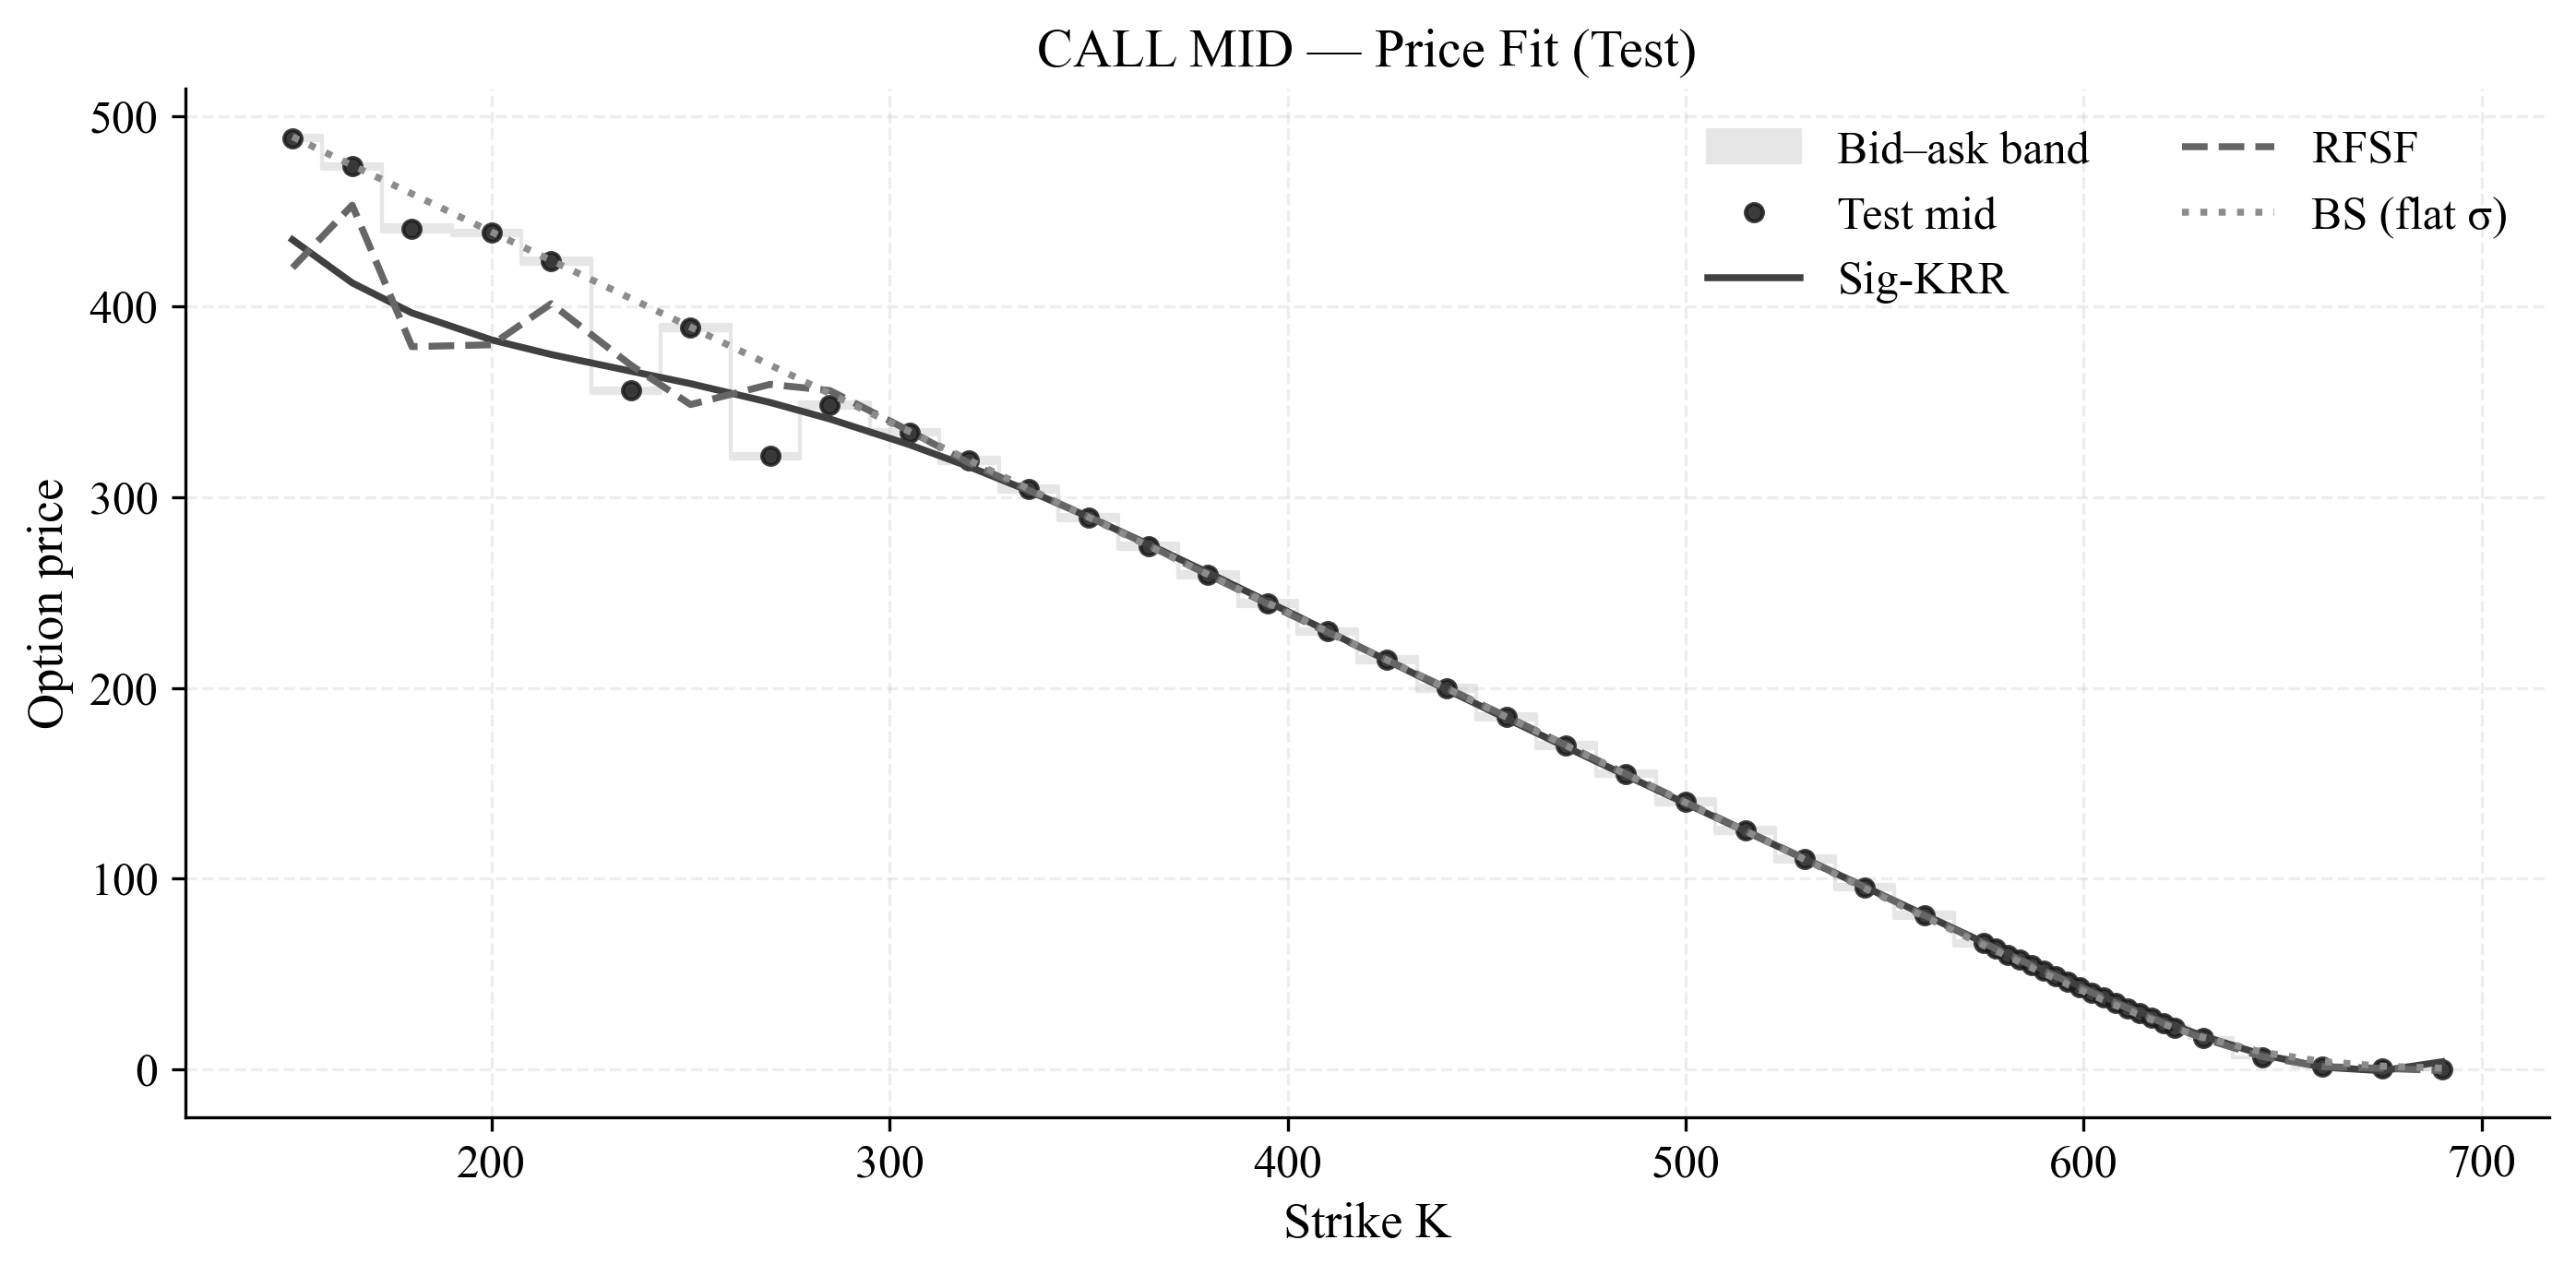

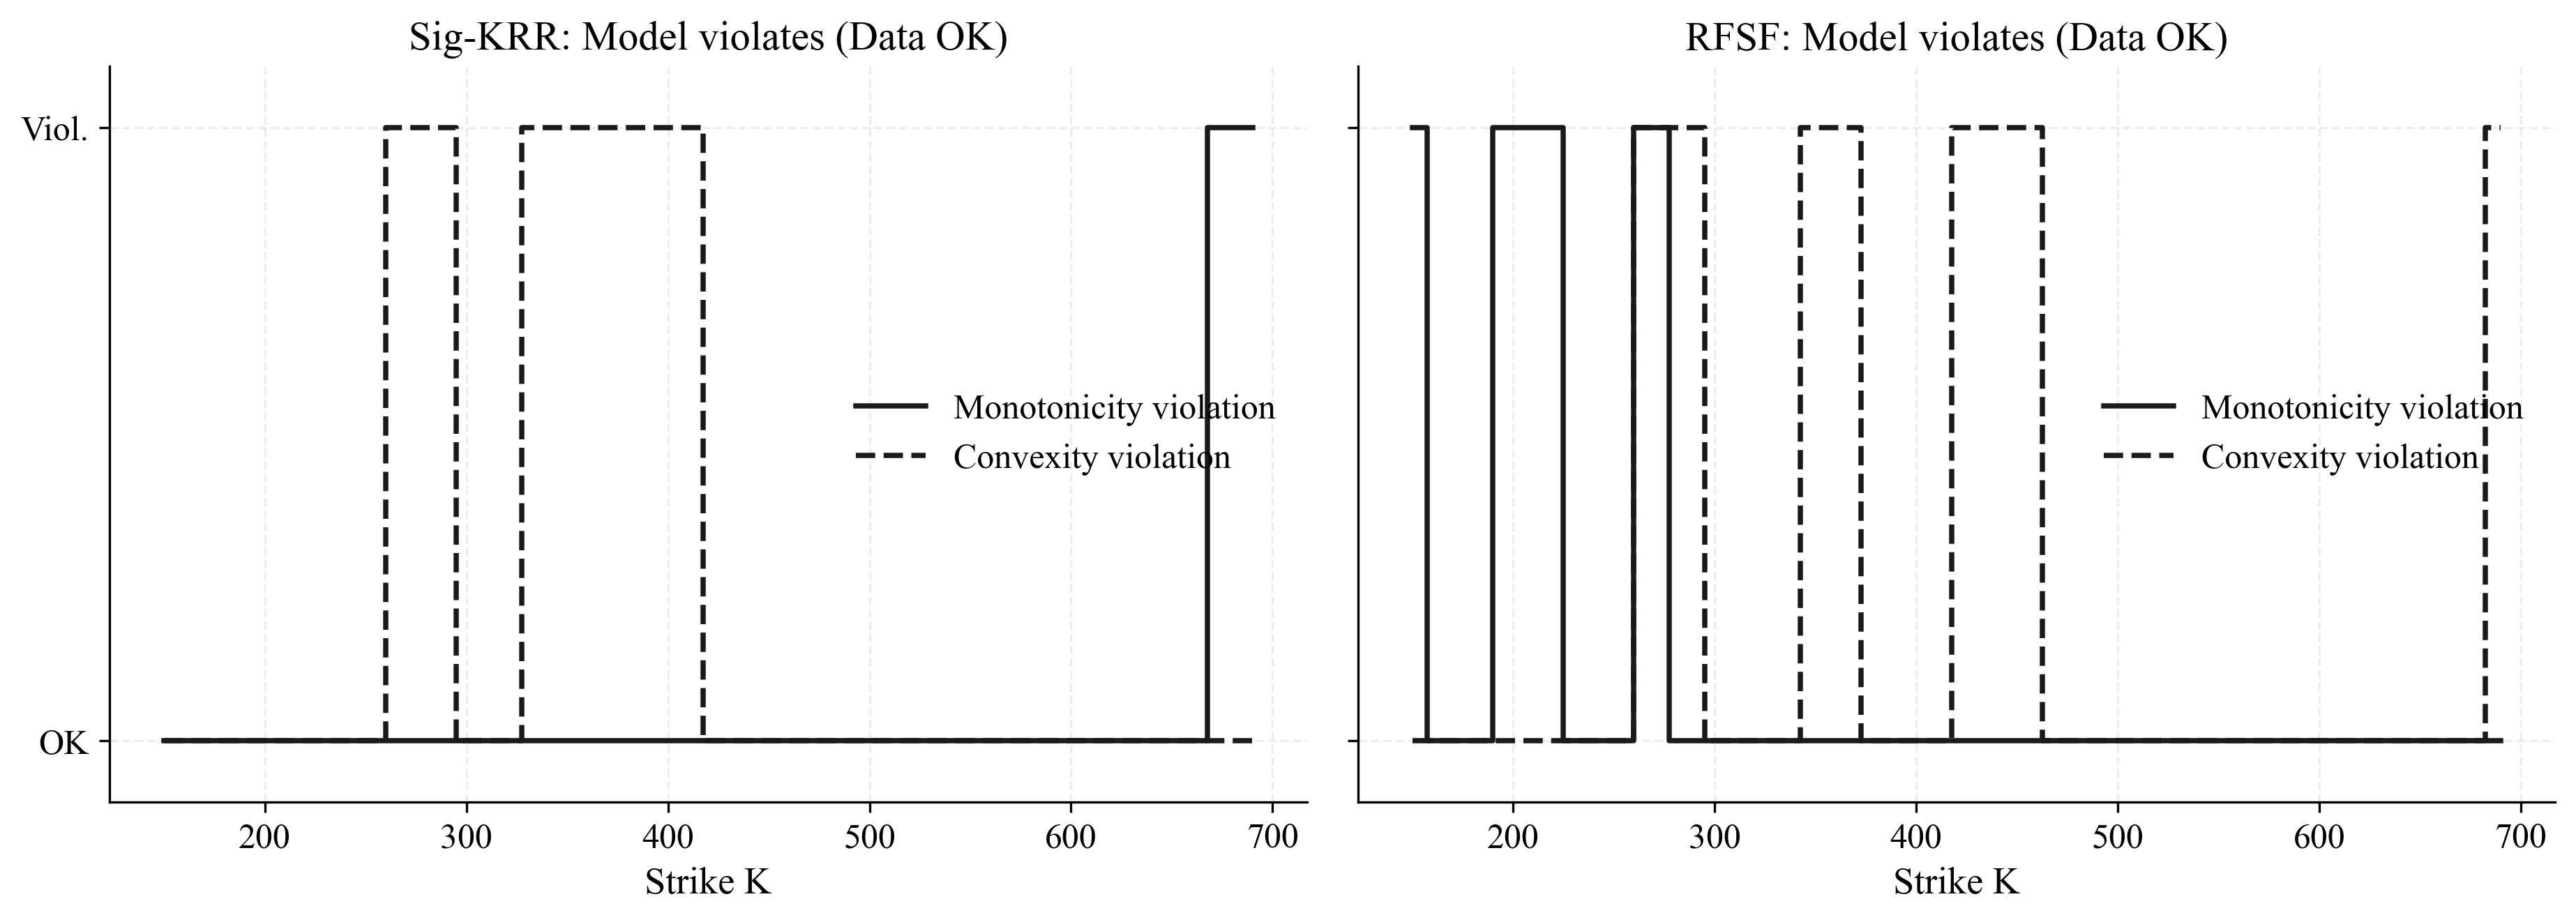

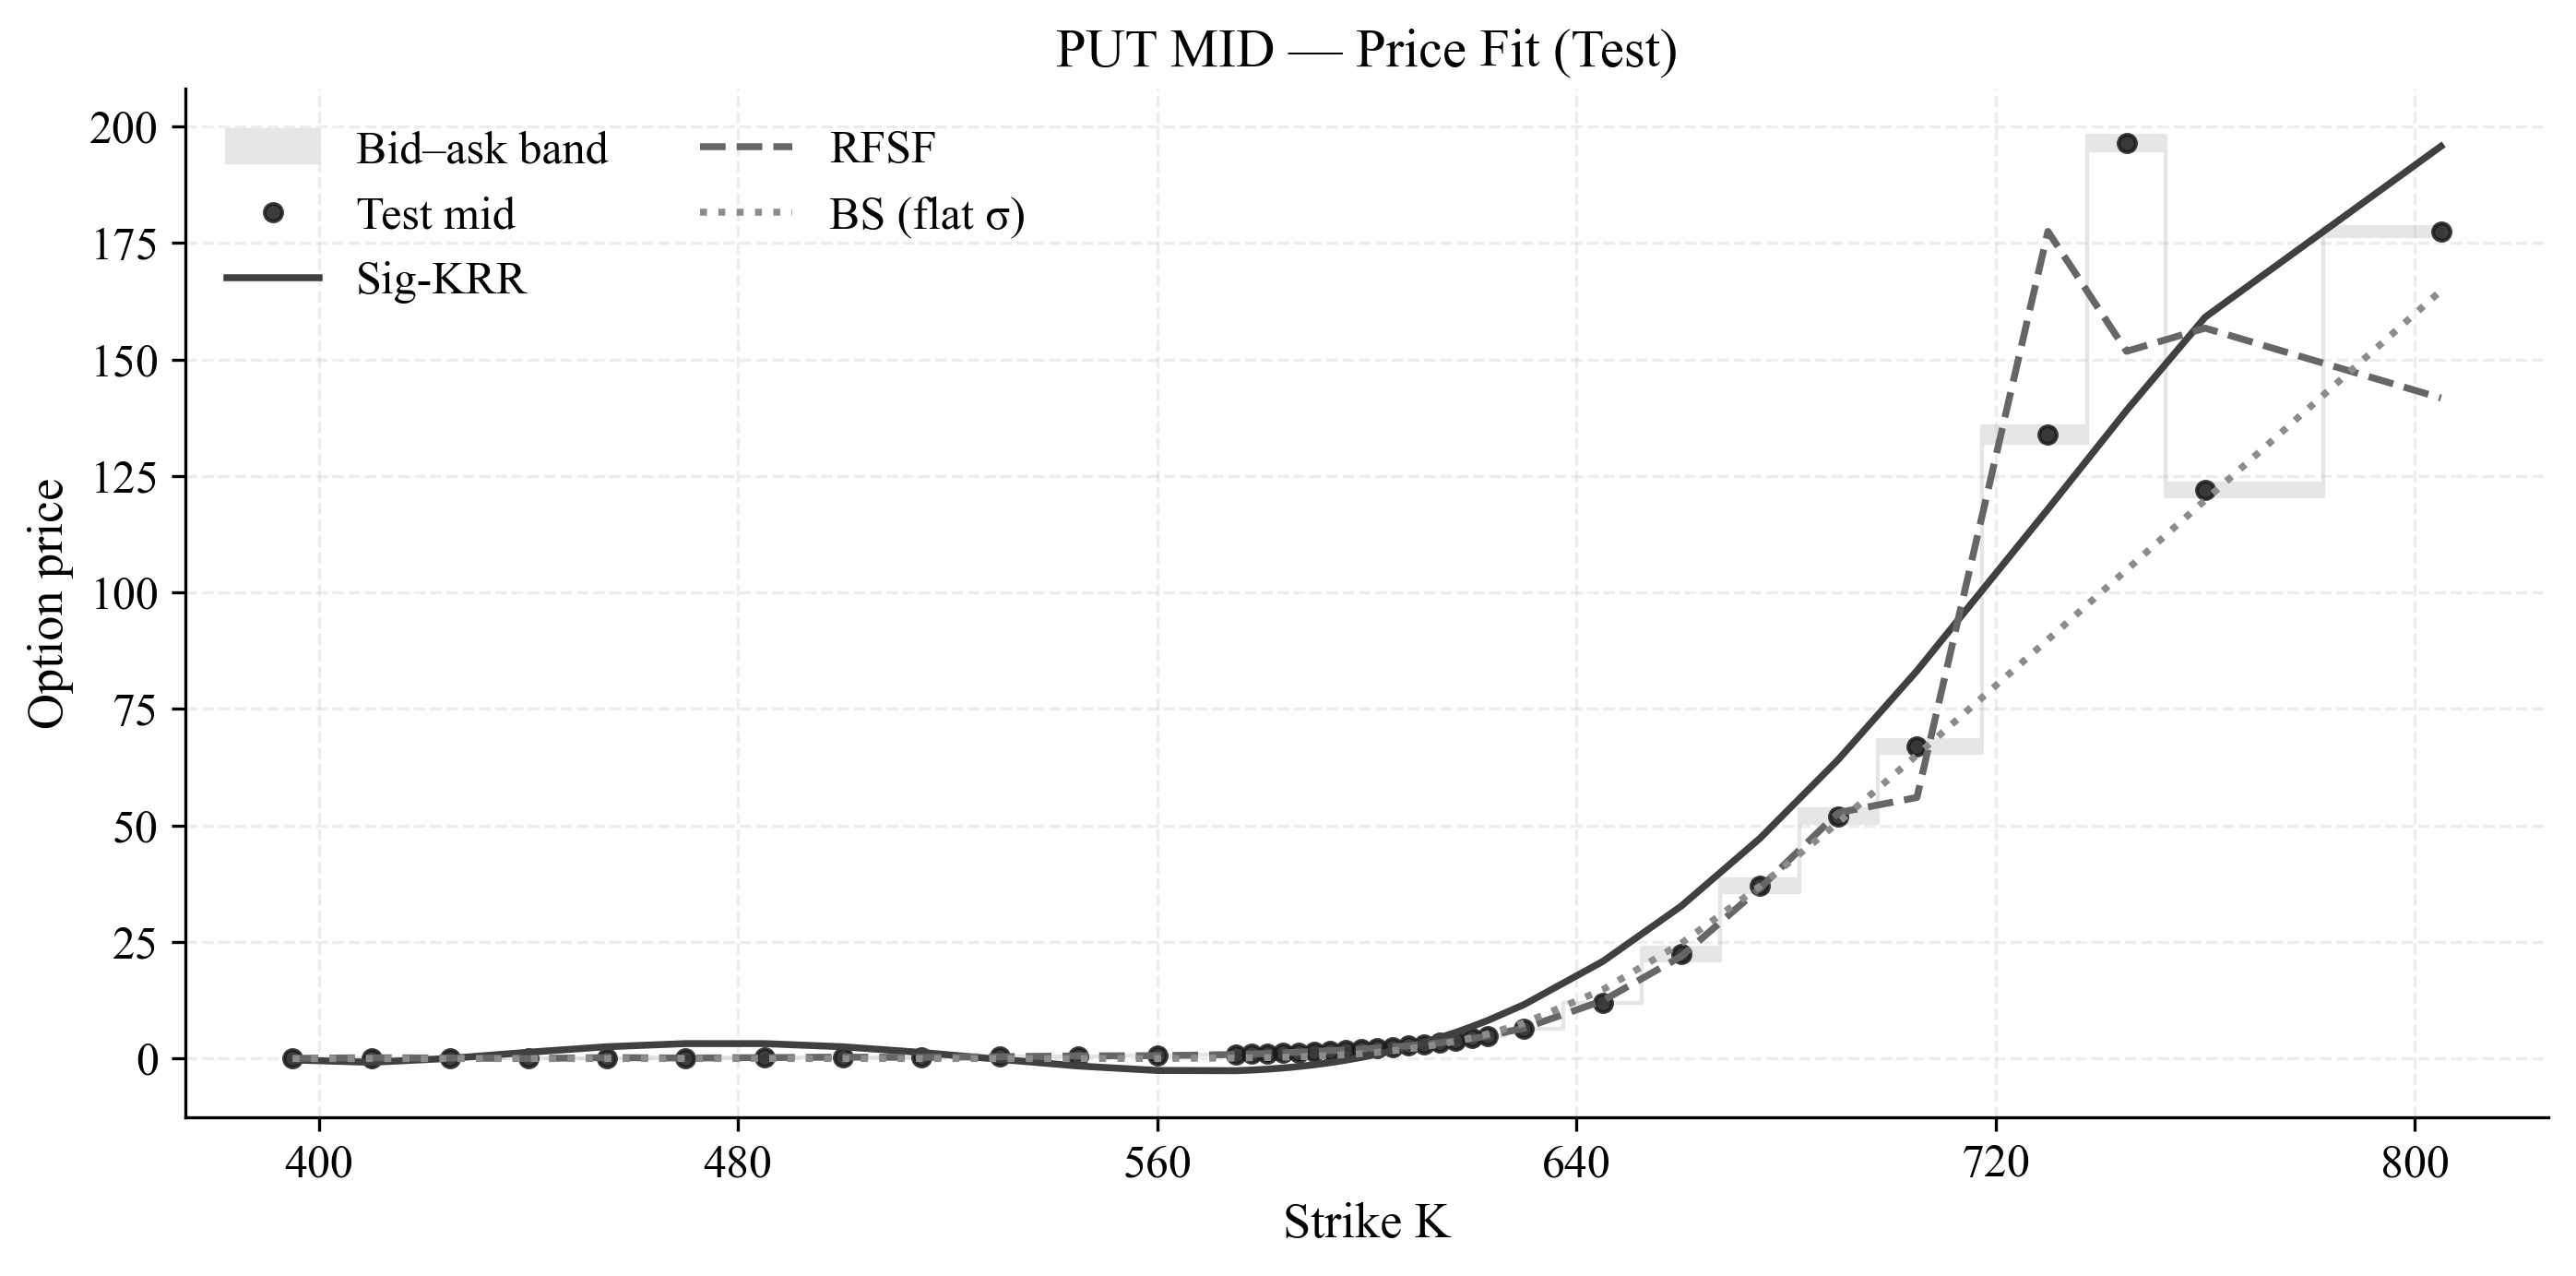

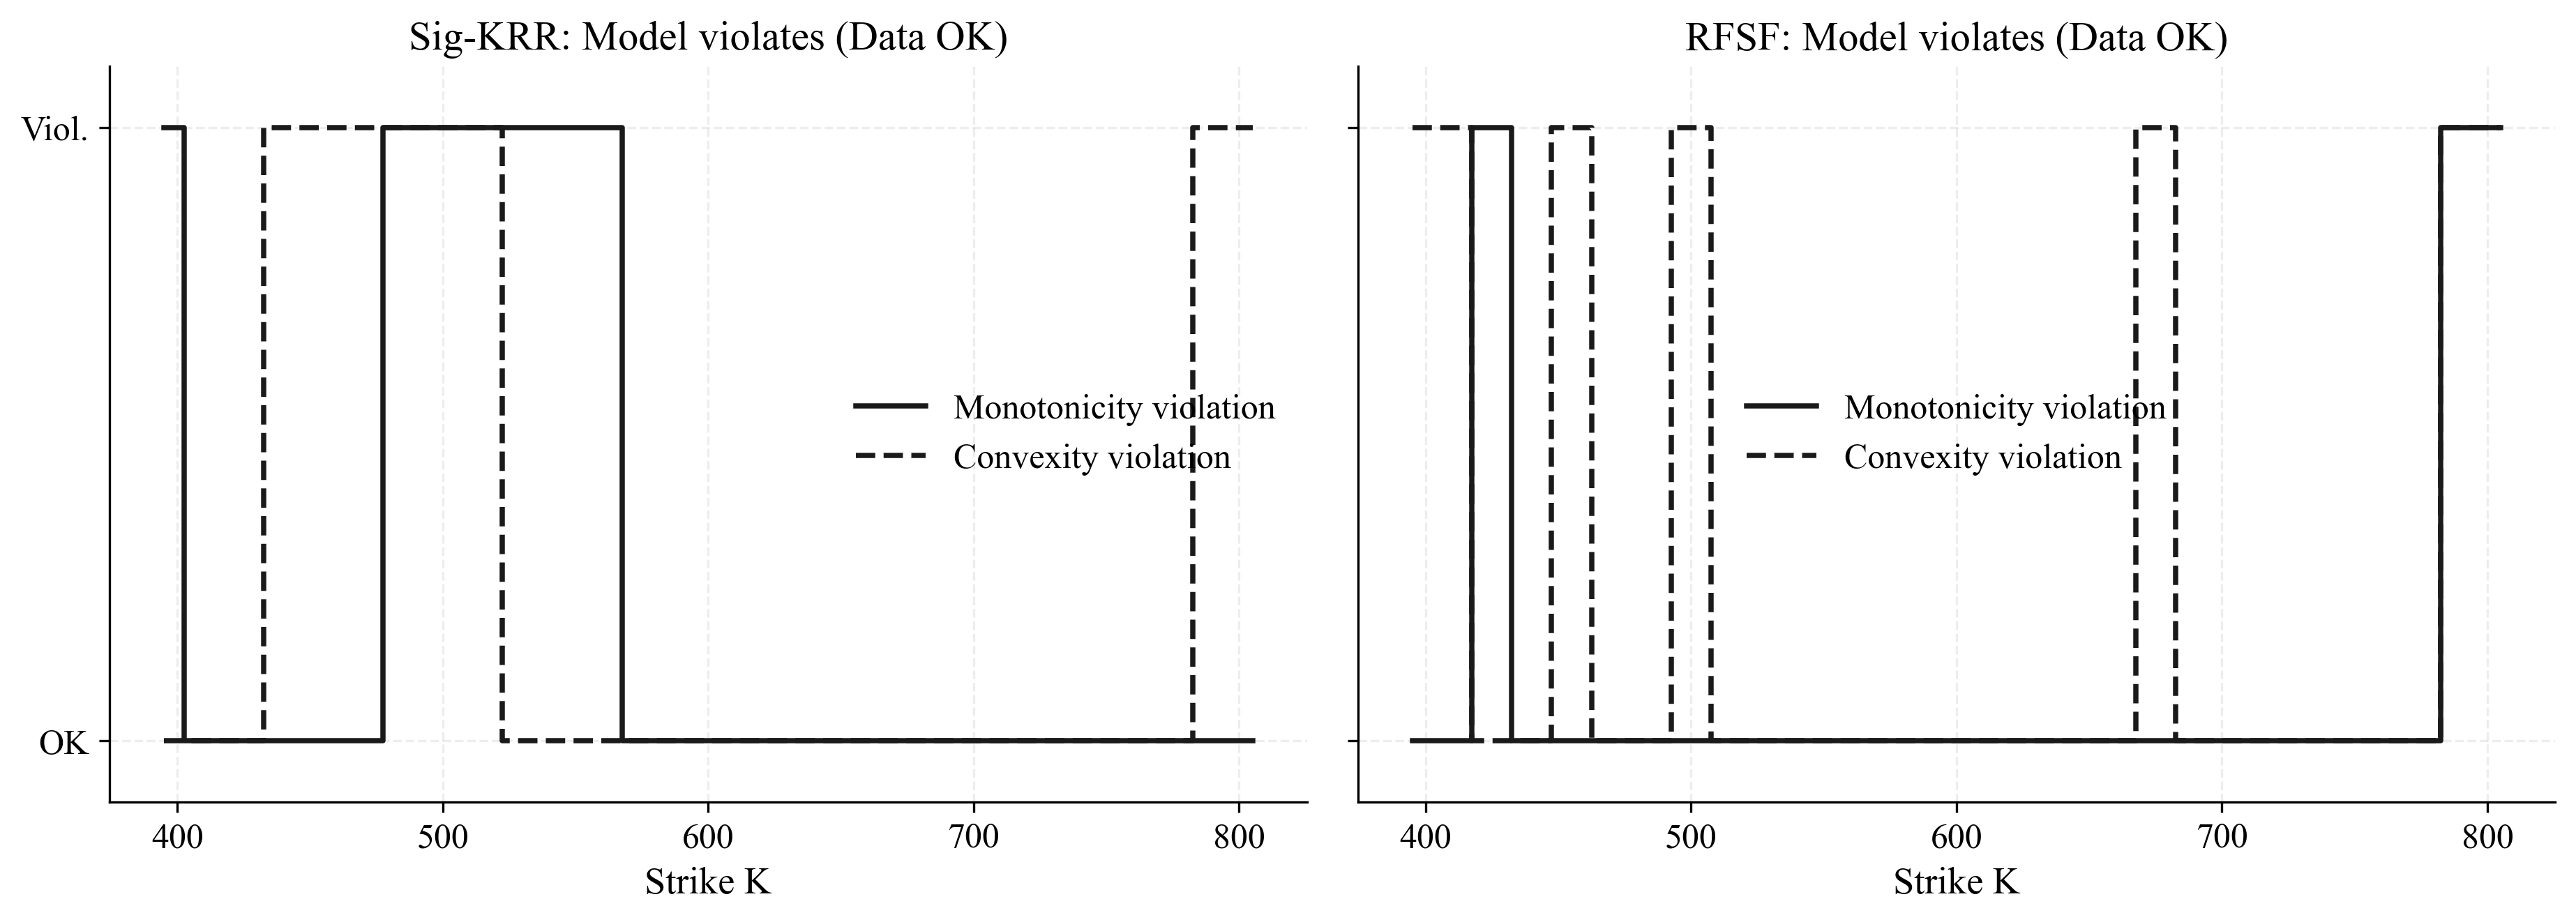

In [24]:
if RUN_PART_B:
    # -------------------- MARKET DATA --------------------
    calls, puts = fetch_options(TICKER, EXPIRY, CSV_CALLS, CSV_PUTS)
    Kc_raw, bid_c_raw, ask_c_raw = clean_chain(calls)
    Kp_raw, bid_p_raw, ask_p_raw = clean_chain(puts)

    today  = dt.date.today()
    expiry = dt.datetime.strptime(EXPIRY, "%Y-%m-%d").date()
    T      = max(1e-8, (expiry - today).days / 365.0)
    S0     = float(yf.Ticker(TICKER).history(period="1d")["Close"][-1])

    mid_c_raw = 0.5*(bid_c_raw+ask_c_raw)
    mid_p_raw = 0.5*(bid_p_raw+ask_p_raw)
    K_par, Cmid_par, Pmid_par = join_common_strikes(Kc_raw, mid_c_raw, Kp_raw, mid_p_raw)
    if len(K_par) >= 3:
        F_est, q_est = estimate_forward_and_q(S0, R_RATE, T, K_par, Cmid_par, Pmid_par)
    else:
        F_est, q_est = S0*np.exp(R_RATE*T), 0.0
    print(f"[INFO] Estimated F={F_est:.4f}, q={q_est:.4%}")

    # -------------------- K-FOLD SPLITS (FIX) --------------------
    def kfold_idxs(n, k=5, seed=RNG_SEED):
        """Yield (train_idx, test_idx) robustly even for small n."""
        if n <= 1:
            yield np.arange(0), np.arange(n)
            return
        k = max(2, min(k, n))  # at least 2 folds, not more than n
        rng = np.random.default_rng(seed)
        idx = np.arange(n)
        rng.shuffle(idx)
        folds = np.array_split(idx, k)
        for i in range(k):
            te = folds[i]
            if te.size == 0:
                continue
            tr = np.setdiff1d(idx, te, assume_unique=False)
            yield tr, te

    # -------------------- TRAIN / PREDICT --------------------
    def evaluate_slice(strikes_all, bid, ask, label, S, r, q, T):
        if len(strikes_all) == 0:
            print(f"[!] {label}: no data.")
            return None

        (Ktr, bid_tr, ask_tr), (Kte, bid_te, ask_te) = split_by_strike(
            strikes_all, bid, ask, test_frac=0.33
        )
        ytr = 0.5*(bid_tr+ask_tr)
        yte = 0.5*(bid_te+ask_te)

        mu, sigma_w = Ktr.mean(), Ktr.std() + 1e-12
        cache = SigCache(mu, sigma_w, SIG_ORDER)
        h = FD_STEP if FD_STEP is not None else adaptive_fd_step(Ktr)
        opt_type = "call" if "CALL" in label.upper() else "put"
        eta = float(ETA_SPREAD)

        D1_full = diff_mat(Ktr)
        D2_full = diff_mat(Ktr) @ diff_mat(Ktr)

        lam_grid   = [1e-6, 1e-5, 1e-4, 1e-3]
        lam_m_grid = [0.0, 1e-3, 1e-2]
        lam_c_grid = [0.0, 1e-3, 1e-2]
        num_folds  = min(CV_FOLDS, max(2, len(Ktr)//5))

        # ----- Sig-KRR (CV) -----
        KXX = signature_kernel_cached(cache, Ktr, Ktr, SIG_ORDER)
        best_score, best_tuple = 1e18, None
        for lam in lam_grid:
            for lam_m in lam_m_grid:
                for lam_c in lam_c_grid:
                    scores = []
                    for tr, te in kfold_idxs(len(Ktr), k=num_folds, seed=RNG_SEED):
                        K_tr = KXX[np.ix_(tr, tr)]
                        y_tr = ytr[tr]; y_te = ytr[te]
                        D1_tr = diff_mat(Ktr[tr]); D2_tr = diff_mat(Ktr[tr]) @ diff_mat(Ktr[tr])
                        P_tr  = D1_tr @ K_tr;  Pm_tr = lam_m * (P_tr.T @ P_tr)
                        Q_tr  = D2_tr @ K_tr;  Qm_tr = lam_c * (Q_tr.T @ Q_tr)
                        A_tr  = (
                            K_tr + lam*np.eye(len(tr)) + Pm_tr + Qm_tr
                            + eta * (K_tr @ D1_tr.T @ D1_tr @ K_tr)
                        )
                        rhs_tr = y_tr + eta * (K_tr @ D1_tr.T @ (D1_tr @ y_tr))
                        alpha_tr = np.linalg.solve(A_tr, rhs_tr)
                        f0  = KXX[np.ix_(te, tr)] @ alpha_tr
                        scores.append(np.mean(np.abs(f0 - y_te)))
                    sc = float(np.mean(scores))
                    if sc < best_score:
                        best_score = sc
                        best_tuple = (lam, lam_m, lam_c)
        lam, lam_m, lam_c = best_tuple

        P  = D1_full @ KXX; Pm = lam_m * (P.T @ P)
        Q  = D2_full @ KXX; Qm = lam_c * (Q.T @ Q)
        A  = (
            KXX + lam*np.eye(len(Ktr)) + Pm + Qm
            + eta * (KXX @ D1_full.T @ D1_full @ KXX)
        )
        s   = D1_full @ ytr
        rhs = ytr + eta * (KXX @ D1_full.T @ s)
        alpha = np.linalg.solve(A, rhs)
        krr_pred = predict_krr(alpha, Ktr, Kte, cache, SIG_ORDER, h)

        # ----- RFSF-Cosine (CV) -----
        Phi_cos = build_RFSF_cosine(cache, SIG_ORDER, D_RFSF)
        Φ_trc   = Phi_cos(Ktr)
        best_score, best_tuple = 1e18, None
        for lam in lam_grid:
            for lam_m in lam_m_grid:
                for lam_c in lam_c_grid:
                    scores = []
                    for tr, te in kfold_idxs(len(Ktr), k=num_folds, seed=RNG_SEED):
                        Φ_tr  = Φ_trc[tr]; y_tr = ytr[tr]; Φ_te = Φ_trc[te]; y_te = ytr[te]
                        D1_tr = diff_mat(Ktr[tr]); D2_tr = diff_mat(Ktr[tr]) @ diff_mat(Ktr[tr])
                        Pm_tr = lam_m * (Φ_tr.T @ D1_tr.T @ D1_tr @ Φ_tr)
                        Qm_tr = lam_c * (Φ_tr.T @ D2_tr.T @ D2_tr @ Φ_tr)
                        A_tr  = (
                            (Φ_tr.T @ Φ_tr) + lam*np.eye(Φ_tr.shape[1]) + Pm_tr + Qm_tr
                            + eta * (Φ_tr.T @ D1_tr.T @ D1_tr @ Φ_tr)
                        )
                        rhs_tr = Φ_tr.T @ y_tr + eta * (Φ_tr.T @ D1_tr.T @ (D1_tr @ y_tr))
                        beta  = np.linalg.solve(A_tr, rhs_tr)
                        f0    = Φ_te @ beta
                        scores.append(np.mean(np.abs(f0 - y_te)))
                    sc = float(np.mean(scores))
                    if sc < best_score:
                        best_score = sc
                        best_tuple = (lam, lam_m, lam_c)
        lam_r, lam_m_r, lam_c_r = best_tuple

        D1 = D1_full; D2 = D2_full
        Pm = lam_m_r * (Φ_trc.T @ D1.T @ D1 @ Φ_trc)
        Qm = lam_c_r * (Φ_trc.T @ D2.T @ D2 @ Φ_trc)
        M  = (
            (Φ_trc.T @ Φ_trc) + lam_r*np.eye(Φ_trc.shape[1]) + Pm + Qm
            + eta * (Φ_trc.T @ D1.T @ D1 @ Φ_trc)
        )
        rhs = Φ_trc.T @ ytr + eta * (Φ_trc.T @ D1.T @ (D1 @ ytr))
        beta_cos = np.linalg.solve(M, rhs)
        RFSF_cos_pred = predict_RFSF(beta_cos, Phi_cos, Kte, h)

        # ----- BS baseline: flat σ -----
        sigma_hat = fit_bs_sigma(Ktr, ytr, S, T, r, q, opt_type)
        bs_pred   = predict_bs(Kte, S, T, r, q, sigma_hat, opt_type, h)

        def maybe_project(Ks, f0):
            if not ENFORCE_NO_ARB:
                return f0, np.gradient(f0, Ks), np.gradient(np.gradient(f0, Ks), Ks)
            f_hat = project_no_arb_1d(Ks, f0, S, T, r, q, opt_type)
            d1 = np.gradient(f_hat, Ks)
            d2 = np.gradient(np.gradient(f_hat, Ks), Ks)
            return f_hat, d1, d2

        krr_pred  = maybe_project(Kte, krr_pred[0])
        RFSF_pred = maybe_project(Kte, RFSF_cos_pred[0])
        bs_pred   = maybe_project(Kte, bs_pred[0])

        # ----- Metrics -----
        def pack_metrics(name, Ks, bid_eval, ask_eval, y, preds):
            f0, d1, d2 = preds
            resid = f0 - y
            rmse  = float(np.sqrt(np.mean(resid**2)))
            mae   = float(np.mean(np.abs(resid)))
            ss    = float(np.sum((y - np.mean(y))**2))
            r2    = 1.0 - float(np.sum(resid**2)) / (ss + 1e-12)
            (mc, ml1), (cc, cl1), _, _ = violations_model_vs_data(
                Ks, y, f0, tol=TOL_VIOL, option_type=opt_type
            )
            tv_d  = total_variation(d1)
            tv_g  = total_variation(d2)
            snmae, hit = spread_metrics(Ks, bid_eval, ask_eval, f0)
            return dict(method=name, rmse=rmse, mae=mae, r2=r2,
                        snmae=snmae, hit_rate=hit,
                        mono_viol_cnt=mc, mono_viol_l1=ml1,
                        conv_viol_cnt=cc, conv_viol_l1=cl1,
                        tv_delta=tv_d, tv_gamma=tv_g), f0

        rows = []
        m1, f1 = pack_metrics("Sig-KRR",     Kte, bid_te, ask_te, yte, krr_pred);  rows.append(m1)
        m2, f2 = pack_metrics("RFSF",        Kte, bid_te, ask_te, yte, RFSF_pred); rows.append(m2)
        m3, f3 = pack_metrics("BS (flat σ)", Kte, bid_te, ask_te, yte, bs_pred);   rows.append(m3)

        df = pd.DataFrame(rows).sort_values(by=["snmae", "rmse"])

        # ----- Bootstrap significance vs baselines -----
        def paired_bootstrap(Ks, bid, ask, preds_dict, B=BOOTSTRAP_B, seed=RNG_SEED):
            rng = np.random.default_rng(seed)
            n = len(Ks); names = list(preds_dict.keys())
            diffs = {f"{a}-{b}":[] for a in names for b in names if a!=b}
            mid = 0.5*(bid+ask); spr = np.maximum(ask-bid, 1e-6)
            for _ in range(B):
                idx = rng.integers(0, n, n)
                errs = {a: np.mean(np.abs(preds_dict[a][idx] - mid[idx]) / spr[idx]) for a in names}
                for a in names:
                    for b in names:
                        if a==b: continue
                        diffs[f"{a}-{b}"].append(errs[a] - errs[b])
            out = {k:(float(np.mean(v)), tuple(np.percentile(v,[2.5,97.5]))) for k,v in diffs.items()}
            return out

        preds_map = {"Sig-KRR": f1, "RFSF": f2, "BS (flat σ)": f3}
        boots = paired_bootstrap(Kte, bid_te, ask_te, preds_map)

        # ----- Plots -----
        fig1, ax = plt.subplots(1, 1, figsize=(9.5, 4.8))
        ax.fill_between(Kte, bid_te, ask_te, color="0.9", step="mid", label="Bid–ask band")
        ax.plot(Kte, yte, "o", color="0.1", label="Test mid", alpha=0.85)
        ax.plot(Kte, f1, "-",  color="0.25", label="Sig-KRR")
        ax.plot(Kte, f2, "--", color="0.4",  label="RFSF")
        ax.plot(Kte, f3, ":",  color="0.55", label="BS (flat σ)")
        ax.set_xlabel("Strike K"); ax.set_ylabel("Option price")
        ax.set_title(f"{label} — Price Fit (Test)")
        ax.legend(frameon=False, ncol=2); ax.xaxis.set_major_locator(MaxNLocator(nbins=7))
        if SAVE_FIGS: save_figure(fig1, f"{label.replace(' ','_')}_price_fit")

        def viol_plot(ax, Ks, y, y_hat, title, opt_type_local):
            (_, _), (_, _), mono_f, conv_f = violations_model_vs_data(
                Ks, y, y_hat, tol=TOL_VIOL, option_type=opt_type_local
            )
            mono = mono_f.astype(int); conv = conv_f.astype(int)
            ax.step(Ks, mono, where="mid", label="Monotonicity violation", linestyle="-",  color="0.1")
            ax.step(Ks, conv, where="mid", label="Convexity violation",    linestyle="--", color="0.1")
            ax.set_ylim(-0.1, 1.1); ax.set_xlabel("Strike K")
            ax.set_yticks([0, 1]); ax.set_yticklabels(["OK", "Viol."])
            ax.set_title(title); ax.legend(frameon=False)

        fig2, axs = plt.subplots(1, 2, figsize=(12.5, 4.6), sharey=True)
        viol_plot(axs[0], Kte, yte, f1, "Sig-KRR: Model violates (Data OK)", opt_type)
        viol_plot(axs[1], Kte, yte, f2, "RFSF: Model violates (Data OK)",    opt_type)
        if SAVE_FIGS: save_figure(fig2, f"{label.replace(' ','_')}_violations")

        print(f"\n=== {label} metrics (test) ===")
        print(df.to_string(index=False, float_format=lambda x: f"{x:,.4f}"))
        print("\nPaired bootstrap Δ(SNMAE) mean [2.5%,97.5%] (negative => row beats col):")
        for a,b in [("Sig-KRR","BS (flat σ)"), ("RFSF","BS (flat σ)"), ("Sig-KRR","RFSF")]:
            mu, (lo,hi) = boots[f"{a}-{b}"]
            print(f"{a:>12} – {b:<14}: {mu: .4f}  [{lo: .4f}, {hi: .4f}]")

        return df, dict(Kte=Kte, bid_te=bid_te, ask_te=ask_te, yte=yte, f1=f1, f2=f2, f3=f3, opt_type=opt_type)

    print("Evaluating CALL MID …")
    df_call, art_call = evaluate_slice(Kc_raw, bid_c_raw, ask_c_raw, "CALL MID", S0, R_RATE, q_est, T)

    print("\nEvaluating PUT MID …")
    df_put, art_put = evaluate_slice(Kp_raw, bid_p_raw, ask_p_raw, "PUT MID",  S0, R_RATE, q_est, T)

    if df_call is not None:
        print("\nCALL metrics (sorted by SNMAE,RMSE):\n", df_call.to_string(index=False))
    if df_put is not None:
        print("\nPUT metrics (sorted by SNMAE,RMSE):\n", df_put.to_string(index=False))
else:
    print("Part B skipped.")


### 🔬 Part B — Extended Metrics (optional)

In [25]:

if RUN_PART_B and RUN_EXTENDED:
    from time import perf_counter
    from scipy.optimize import brentq

    def finite_diff_first(x, y):
        x = np.asarray(x, float); y = np.asarray(y, float)
        d = np.zeros_like(y)
        d[1:-1] = (y[2:] - y[:-2]) / (x[2:] - x[:-2])
        if len(y) >= 2:
            d[0]  = (y[1] - y[0]) / (x[1] - x[0])
            d[-1] = (y[-1] - y[-2]) / (x[-1] - x[-2])
        return d

    def finite_diff_second(x, y):
        x = np.asarray(x, float); y = np.asarray(y, float)
        d2 = np.zeros_like(y)
        for i in range(1, len(y)-1):
            h1 = x[i] - x[i-1]; h2 = x[i+1] - x[i]
            d2[i] = 2 * ( (y[i+1]-y[i]) / (h2*(h1+h2)) - (y[i]-y[i-1]) / (h1*(h1+h2)) )
        if len(y) >= 3:
            d2[0]  = d2[1]
            d2[-1] = d2[-2]
        return d2

    def bs_price_minus_target(sigma, K, S, T, r, q, target, option_type):
        return black_scholes_price(K, S, T, r, q, max(sigma, 1e-12), option_type) - target

    def implied_vol_vector(prices, K, S, T, r, q, option_type="call"):
        prices = np.asarray(prices, float); K = np.asarray(K, float)
        iv = np.full_like(prices, np.nan, dtype=float)
        for i, (p, k) in enumerate(zip(prices, K)):
            if not np.isfinite(p) or p <= 0: continue
            if option_type == "call":
                lower = max(S*np.exp(-q*T) - k*np.exp(-r*T), 0.0)
            else:
                lower = max(k*np.exp(-r*T) - S*np.exp(-q*T), 0.0)
            upper = max(S*np.exp(-q*T), k*np.exp(-r*T))
            p = float(np.clip(p, lower + 1e-12, upper - 1e-12))
            try:
                root = brentq(bs_price_minus_target, 1e-6, 5.0, args=(k, S, T, r, q, p, option_type), maxiter=200)
                iv[i] = root
            except Exception:
                grid = np.geomspace(1e-4, 3.0, 80)
                vals = [abs(black_scholes_price(k, S, T, r, q, s, option_type)-p) for s in grid]
                iv[i] = grid[int(np.argmin(vals))]
        return iv

    def smoothness_metrics(K, delta_hat, gamma_hat):
        K = np.asarray(K, float)
        rng = max(K.max() - K.min(), 1e-12)
        tv_delta = total_variation(delta_hat) / rng
        tv_gamma = total_variation(gamma_hat) / rng
        mean_abs_gamma = np.mean(np.abs(gamma_hat)) + 1e-12
        gamma_osc_ratio = tv_gamma / mean_abs_gamma
        coeffs = np.polyfit(K, gamma_hat, deg=3)
        fit = np.polyval(coeffs, K)
        ss_res = np.sum((gamma_hat - fit)**2)
        ss_tot = np.sum((gamma_hat - np.mean(gamma_hat))**2) + 1e-12
        gamma_r2_poly3 = 1.0 - ss_res / ss_tot
        return dict(delta_tv_norm=tv_delta, gamma_tv_norm=tv_gamma,
                    gamma_osc_ratio=gamma_osc_ratio, gamma_r2_poly3=gamma_r2_poly3)

    def hedge_error_metrics(K, bid, ask, price_hat):
        mid = 0.5*(bid+ask)
        d_mid = finite_diff_first(K, mid); g_mid = finite_diff_second(K, mid)
        d_hat = finite_diff_first(K, price_hat); g_hat = finite_diff_second(K, price_hat)
        return dict(delta_mae=float(np.mean(np.abs(d_hat - d_mid))),
                    gamma_mae=float(np.mean(np.abs(g_hat - g_mid))))

    def iv_space_metrics(K, bid, ask, S, T, r, q, price_hat, opt_type):
        mid = 0.5*(bid+ask)
        iv_mkt = implied_vol_vector(mid, K, S, T, r, q, option_type=opt_type)
        iv_hat = implied_vol_vector(price_hat, K, S, T, r, q, option_type=opt_type)
        m = np.isfinite(iv_mkt) & np.isfinite(iv_hat)
        if not np.any(m):
            return dict(iv_rmse=np.nan, iv_mae=np.nan, iv_snmae=np.nan)
        rmse = float(np.sqrt(np.mean((iv_hat[m] - iv_mkt[m])**2)))
        mae  = float(np.mean(np.abs(iv_hat[m] - iv_mkt[m])))
        denom = np.median(np.abs(iv_mkt[m])) + 1e-12
        snmae = float(np.mean(np.abs(iv_hat[m] - iv_mkt[m]) / denom))
        return dict(iv_rmse=rmse, iv_mae=mae, iv_snmae=snmae)

    def bucket_by_moneyness(K, S): return K / S

    def bucket_metrics(K, bid, ask, price_hat, S, is_call=True):
        m = bucket_by_moneyness(K, S)
        mid = 0.5*(bid+ask); spr = np.maximum(ask-bid, 1e-6); errs = np.abs(price_hat - mid)
        out = {}
        atm = (m >= 0.95) & (m <= 1.05)
        if is_call:
            otm = m > 1.05; itm = m < 0.95
        else:
            otm = m < 0.95; itm = m > 1.05
        for name, mask in [("ATM", atm), ("OTM", otm), ("ITM", itm)]:
            if np.any(mask):
                out[name] = dict(
                    rmse=float(np.sqrt(np.mean((price_hat[mask]-mid[mask])**2))),
                    snmae=float(np.mean(errs[mask] / spr[mask])),
                    mae=float(np.mean(errs[mask])),
                    n=int(np.sum(mask)),
                )
            else:
                out[name] = dict(rmse=np.nan, snmae=np.nan, mae=np.nan, n=0)
        return out

    def summarize_extended(K, bid, ask, y, S, r, q, T, opt_type, preds_map):
        def build_row(tag, f0):
            d1 = np.gradient(f0, K); d2 = np.gradient(np.gradient(f0, K), K)
            snmae, hit = spread_metrics(K, bid, ask, f0)
            rmse = float(np.sqrt(np.mean((f0 - y)**2)))
            mae  = float(np.mean(np.abs(f0 - y)))
            sm = smoothness_metrics(K, d1, d2)
            he = hedge_error_metrics(K, bid, ask, f0)
            ivm = iv_space_metrics(K, bid, ask, S, T, r, q, f0, opt_type)
            is_call = (opt_type == "call")
            buck = bucket_metrics(K, bid, ask, f0, S, is_call=is_call)
            return {
                "method": tag, "rmse": rmse, "mae": mae, "snmae": snmae, "hit": hit,
                "delta_tv_norm": sm["delta_tv_norm"], "gamma_tv_norm": sm["gamma_tv_norm"],
                "gamma_osc_ratio": sm["gamma_osc_ratio"], "gamma_r2_poly3": sm["gamma_r2_poly3"],
                "delta_mae": he["delta_mae"], "gamma_mae": he["gamma_mae"],
                "iv_rmse": ivm["iv_rmse"], "iv_mae": ivm["iv_mae"], "iv_snmae": ivm["iv_snmae"],
                "ATM_snmae": buck["ATM"]["snmae"], "OTM_snmae": buck["OTM"]["snmae"], "ITM_snmae": buck["ITM"]["snmae"],
                "ATM_rmse": buck["ATM"]["rmse"], "OTM_rmse": buck["OTM"]["rmse"], "ITM_rmse": buck["ITM"]["rmse"],
                "ATM_n": buck["ATM"]["n"], "OTM_n": buck["OTM"]["n"], "ITM_n": buck["ITM"]["n"],
            }
        rows = [build_row(name, preds_map[name]) for name in ["Sig-KRR","RFSF","BS (flat σ)"] if name in preds_map]
        df = pd.DataFrame(rows).sort_values(by=["snmae","rmse"]).reset_index(drop=True)
        keep = ["method","rmse","snmae","hit","iv_rmse","iv_snmae","delta_mae","gamma_mae",
                "delta_tv_norm","gamma_osc_ratio","gamma_r2_poly3",
                "ATM_snmae","OTM_snmae","ITM_snmae"]
        display(df[keep])
        return df

    print("\n[EXT] Extended CALL analysis …")
    df_call_ext = summarize_extended(art_call["Kte"], art_call["bid_te"], art_call["ask_te"], art_call["yte"],
                                     S0, R_RATE, q_est, T, art_call["opt_type"],
                                     {"Sig-KRR": art_call["f1"], "RFSF": art_call["f2"], "BS (flat σ)": art_call["f3"]})

    print("\n[EXT] Extended PUT analysis …")
    df_put_ext = summarize_extended(art_put["Kte"], art_put["bid_te"], art_put["ask_te"], art_put["yte"],
                                    S0, R_RATE, q_est, T, art_put["opt_type"],
                                    {"Sig-KRR": art_put["f1"], "RFSF": art_put["f2"], "BS (flat σ)": art_put["f3"]})
else:
    if RUN_PART_B:
        print("Extended analysis skipped.")



[EXT] Extended CALL analysis …


,method,rmse,snmae,hit,iv_rmse,iv_snmae,delta_mae,gamma_mae,delta_tv_norm,gamma_osc_ratio,gamma_r2_poly3,ATM_snmae,OTM_snmae,ITM_snmae
0,RFSF,18.127286,4.685361,0.734694,0.225076,0.274649,0.246859,0.051658,0.027823,0.081484,0.452784,1.187811,51.087118,3.071531
1,BS (flat σ),10.120704,8.649467,0.673469,0.107318,0.256440,0.106690,0.036079,0.001723,0.015184,0.608933,22.327424,85.488469,1.365793
2,Sig-KRR,18.052743,14.030889,0.632653,0.215782,0.428234,0.149497,0.037995,0.005560,0.023910,0.738191,8.753044,240.601896,3.356115



[EXT] Extended PUT analysis …


,method,rmse,snmae,hit,iv_rmse,iv_snmae,delta_mae,gamma_mae,delta_tv_norm,gamma_osc_ratio,gamma_r2_poly3,ATM_snmae,OTM_snmae,ITM_snmae
0,RFSF,12.916107,4.976271,0.179487,0.211588,0.352929,0.116514,0.047546,0.016491,0.104490,0.046777,4.027029,4.224985,8.665235
1,BS (flat σ),16.423838,38.615890,0.051282,0.350045,0.812554,0.186809,0.031989,0.002435,0.016137,0.526614,26.903105,52.830575,6.969789
2,Sig-KRR,12.531617,143.270158,0.000000,0.269045,0.891460,0.251923,0.034867,0.005816,0.016736,0.773556,91.991889,204.409838,8.311843



---

## 📁 Outputs
- Tables: `paper_outputs/`  
- Figures: `figures/`